# FASE 1: Càrrega i Pre-processament de Dades

En aquesta primera fase, establim la base operativa del projecte carregant el conjunt de dades relacional i aplicant els filtres necessaris per garantir la coherència temporal i econòmica de l'estudi.

Els objectius d'aquest bloc de codi són:

1.  **Càrrega de Fonts:** Importació dels fitxers troncals (`players`, `transfers`, `appearances`, `valuations`).
2.  **Coherència Temporal:** Com que el dataset inclou operacions pactades a futur, apliquem un filtre per analitzar només els moviments realitzats fins a la data actual (**7 de gener de 2026**).
3.  **Definició de l'Univers d'Estudi:** D'acord amb l'objectiu de mesurar l'**Eficiència del Capital**, filtrem el dataset per conservar únicament els fitxatges que han comportat una inversió econòmica (`transfer_fee > 0`). Les operacions a cost zero (lliures) queden excloses d'aquesta anàlisi específica de ROI.
4.  **Neteja Inicial:** Estandarització de dates i tractament de valors nuls en els imports.

In [1]:
!pip install kagglehub

In [2]:
import kagglehub
import pandas as pd
import os # Necessari per combinar la ruta amb el nom del fitxer

# 1. DESCARREGAR (O ACTUALITZAR) EL DATASET
print("Descarregant/Buscant dades...")
path = kagglehub.dataset_download("davidcariboo/player-scores")
print("✅ Dades disponibles a:", path)

# 2. CARREGAR ELS CSVS FENT SERVIR LA RUTA 'path'
# Fim servir os.path.join per enganxar la ruta de la carpeta amb el nom del fitxer
try:
    df_players = pd.read_csv(os.path.join(path, 'players.csv'))
    df_transfers = pd.read_csv(os.path.join(path, 'transfers.csv'))
    df_appearances = pd.read_csv(os.path.join(path, 'appearances.csv'))
    df_valuations = pd.read_csv(os.path.join(path, 'player_valuations.csv'))

    print("✅ Tots els fitxers carregats correctament a la memòria!")

    # 3. VERIFICAR QUE S'HAN CARREGAT BÉ
    print(f"\nExemple: Tenim {len(df_players)} jugadors carregats.")
    display(df_transfers.head(3))

except FileNotFoundError as e:
    print(f"❌ Error: No trobo el fitxer dins la carpeta descarregada. Revisa el nom: {e}")

Descarregant/Buscant dades...
Using Colab cache for faster access to the 'player-scores' dataset.
✅ Dades disponibles a: /kaggle/input/player-scores
✅ Tots els fitxers carregats correctament a la memòria!

Exemple: Tenim 32601 jugadors carregats.


,player_id,transfer_date,transfer_season,from_club_id,to_club_id,from_club_name,to_club_name,transfer_fee,market_value_in_eur,player_name
0,16136,2026-07-01,26/27,417,123,OGC Nice,Retired,NaN,500000.0,Dante
1,1138758,2026-07-01,26/27,336,631,Sporting CP,Chelsea,52140000.0,45000000.0,Geovany Quenda
2,195778,2026-06-30,25/26,79,27,VfB Stuttgart,Bayern Munich,0.0,12000000.0,Alexander Nübel


In [3]:
# 1. NETEJA DE DATES (Actualitzada a la realitat 2026)
df_transfers['transfer_date'] = pd.to_datetime(df_transfers['transfer_date'])

# Filtrem: Tot el que hagi passat fins AVUI (7 de gener de 2026)
# Eliminem el que està programat per l'estiu del 26 (futur)
data_limit = '2026-01-07'
df_transfers_clean = df_transfers[df_transfers['transfer_date'] < data_limit].copy()

print(f"Data límit aplicada: {data_limit}")
print(f"Fitxatges totals: {len(df_transfers)}")
print(f"Fitxatges passats (reals): {len(df_transfers_clean)}")

# 2. NETEJA DE DINERS
df_transfers_clean['transfer_fee'] = df_transfers_clean['transfer_fee'].fillna(0)

# 3. FILTREM ELS FITXATGES "DE PAGAMENT" (> 0€)
df_inversions = df_transfers_clean[df_transfers_clean['transfer_fee'] > 0].copy()

print(f"Fitxatges amb cost econòmic (> 0€): {len(df_inversions)}")

# 4. TOP 5 HISTÒRIC (A veure si surt Neymar o algun animalada nova del 2025)
print("\n--- TOP 5 FITXATGES MÉS CARS FINS AVUI ---")
cols_interes = ['player_name', 'transfer_date', 'from_club_name', 'to_club_name', 'transfer_fee']
display(df_inversions[cols_interes].sort_values(by='transfer_fee', ascending=False).head(5))

Data límit aplicada: 2026-01-07
Fitxatges totals: 79646
Fitxatges passats (reals): 79637
Fitxatges amb cost econòmic (> 0€): 9508

--- TOP 5 FITXATGES MÉS CARS FINS AVUI ---


,player_name,transfer_date,from_club_name,to_club_name,transfer_fee
47851,Kylian Mbappé,2018-07-01,Monaco,Paris SG,180000000.0
51801,Ousmane Dembélé,2017-08-25,Bor. Dortmund,Barcelona,135000000.0
50887,Philippe Coutinho,2018-01-08,Liverpool,Barcelona,135000000.0
41214,João Félix,2019-07-03,Benfica,Atlético Madrid,127200000.0
16528,Enzo Fernández,2023-01-31,Benfica,Chelsea,121000000.0


📅 PRIMER fitxatge registrat: 2002-07-01
📅 ÚLTIM fitxatge registrat: 2025-07-01
⏳ Període total: 23 anys

--- VOLUM DE FITXATGES PER ANY ---
transfer_date
2002       1
2004       6
2005      13
2006      14
2007      43
2008      39
2009      64
2010      80
2011     144
2012     159
2013     260
2014     284
2015     401
2016     476
2017     625
2018     678
2019     871
2020     738
2021     757
2022    1099
2023    1262
2024    1201
2025     293
Name: count, dtype: int64


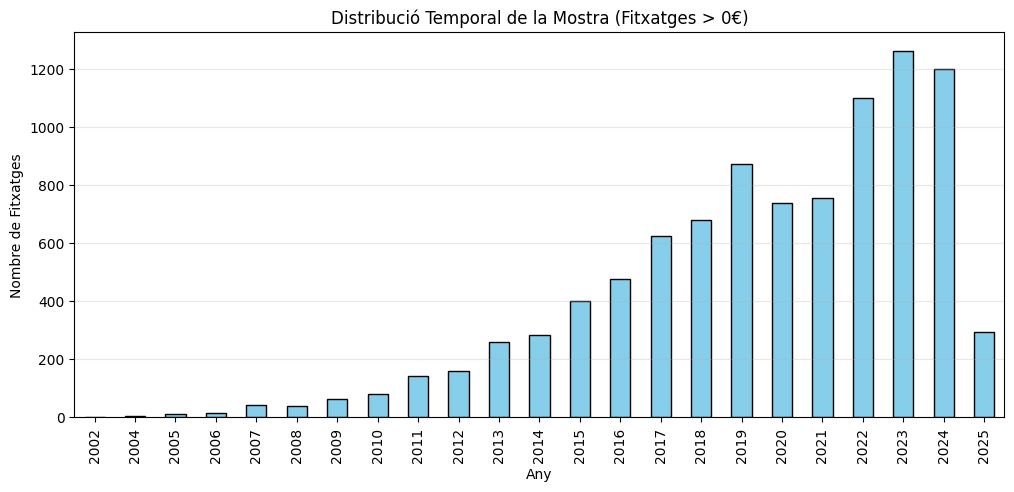

In [4]:
# 1. RANG DE DATES EXACTE
data_min = df_inversions['transfer_date'].min()
data_max = df_inversions['transfer_date'].max()

print(f"📅 PRIMER fitxatge registrat: {data_min.date()}")
print(f"📅 ÚLTIM fitxatge registrat: {data_max.date()}")
print(f"⏳ Període total: {data_max.year - data_min.year} anys")

# 2. DISTRIBUCIÓ PER ANYS (Vital per veure la consistència)
# Volem saber si tenim dades sòlides de tots els anys o només dels recents
anys = df_inversions['transfer_date'].dt.year.value_counts().sort_index()

print("\n--- VOLUM DE FITXATGES PER ANY ---")
print(anys)

# 3. GRÀFIC RÀPID
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
anys.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribució Temporal de la Mostra (Fitxatges > 0€)')
plt.ylabel('Nombre de Fitxatges')
plt.xlabel('Any')
plt.grid(axis='y', alpha=0.3)
plt.show()

### 1.2. Definició de l'Univers Temporal

L'anàlisi de la distribució temporal de les dades revela un biaix significatiu de cobertura en els primers anys del registre. El creixement exponencial observat al gràfic no respon únicament a un augment del volum de mercat, sinó a l'evolució de la pròpia font de dades (*Transfermarkt*), que en els seus inicis registrava només operacions d'alt perfil mediàtic.

Per garantir la **robustesa estadística** i evitar l'heterogeneïtat de la mostra (comparar anys amb cobertura parcial vs. anys amb cobertura total), apliquem el següent criteri de tall:

* **Exclusió de la "Cua Esquerra" (< 2015):** Eliminem els anys on la mostra és inferior a 400 operacions anuals per evitar biaixos cap a "jugadors estrella".
* **Exclusió de la "Cua Dreta" (> 2024):** Eliminem l'any 2025 i posteriors perquè les dades són incompletes o provisionals.
* **Període d'Estudi Definitiu:** Ens centrem en la **Dècada Moderna (2015-2024)**, un període que garanteix una densitat de dades suficient i homogènia per analitzar les dinàmiques de preus actuals.

In [5]:
# DEFINIM L'ERA MODERNA PER EVITAR BIAIXOS
any_inici = 2015
any_final = 2024  # Excloem el 2025, està incomplet

print(f"🔪 TALLANT DADES: Ens quedem només amb el període {any_inici}-{any_final}...")

# Filtrem pel rang d'anys
df_inversions_final = df_inversions[
    (df_inversions['transfer_date'].dt.year >= any_inici) &
    (df_inversions['transfer_date'].dt.year <= any_final)
].copy()

print(f"Fitxatges inicials (>0€): {len(df_inversions)}")
print(f"Fitxatges finals (Era Moderna): {len(df_inversions_final)}")

# Comprovem que ens queden prous dades
if len(df_inversions_final) > 5000:
    print("✅ MOSTRA EXCEL·LENT: Tenim prou dades per fer estadística robusta.")
else:
    print("⚠️ ALERTA: La mostra és una mica justa, però continuem.")

# Guardem aquest dataset com el bo per seguir treballant
df_main = df_inversions_final.reset_index(drop=True)
df_main.head()

🔪 TALLANT DADES: Ens quedem només amb el període 2015-2024...
Fitxatges inicials (>0€): 9508
Fitxatges finals (Era Moderna): 8108
✅ MOSTRA EXCEL·LENT: Tenim prou dades per fer estadística robusta.


,player_id,transfer_date,transfer_season,from_club_id,to_club_id,from_club_name,to_club_name,transfer_fee,market_value_in_eur,player_name
0,248355,2024-09-13,24/25,62,126,Slavia Prague,C. Rizespor,1200000.0,1700000.0,Vaclav Jurecka
1,332798,2024-09-13,24/25,60,141,SC Freiburg,Galatasaray,6000000.0,15000000.0,Roland Sallai
2,461657,2024-09-13,24/25,999,589,NK Istra,Antalyaspor,500000.0,1000000.0,Oleksandr Petrusenko
3,268167,2024-09-12,24/25,648,3719,CD Tenerife,Khimki,500000.0,1000000.0,Àlex Corredera
4,322288,2024-09-12,24/25,255,2293,Legia Warszawa,Konyaspor,700000.0,500000.0,Blaz Kramer


# FASE 2: Enriquiment de Dades (Vinculació Rendiment-Inversió)

Un cop aïllada la mostra d'inversions rellevants (2015-2024), procedim a la fase més crítica de l'enginyeria de dades: la fusió de taules. En aquest pas, enriquim cada registre de traspàs amb dues dimensions fonamentals per al càlcul de l'eficiència:

1.  **Dimensió Posicional:** Incorporem la posició tàctica del jugador des de la taula `players`. Aquesta variable és un requisit previ indispensable per aplicar els **Coeficients de Ponderació ($k$)** definits a la metodologia (no s'avalua igual un davanter que un defensa).
2.  **Dimensió de Rendiment:** Agreguem la taula `appearances` per calcular el volum total de minuts, gols i assistències que el jugador va generar específicament per al club de destinació.

**Nota Tècnica:** La vinculació es realitza mitjançant una clau composta (`player_id` + `club_id`) per garantir que s'assignen les estadístiques correctes a l'etapa corresponent.

In [6]:
# 1. PREPARAR LA TAULA DE POSICIONS
# Necessitem saber si és "Defender", "Attacker", etc. per aplicar les K.
# La taula players té 'position'.
cols_players = ['player_id', 'position']
# Fem un merge per afegir la posició al nostre dataset principal
df_merged = df_main.merge(df_players[cols_players], on='player_id', how='left')

print("✅ Posicions afegides.")

# 2. AGREGAR EL RENDIMENT (La part pesada)
# Agrupem 'appearances' per jugador i club per tenir el total de la seva estada
print("Calculant estadístiques acumulades (pot trigar uns segons)...")

stats_agregades = df_appearances.groupby(['player_id', 'player_club_id'])[['goals', 'assists', 'minutes_played']].sum().reset_index()

# Canviem el nom de 'player_club_id' a 'to_club_id' per poder fer el match amb fitxatges
stats_agregades = stats_agregades.rename(columns={'player_club_id': 'to_club_id'})

# 3. EL GRAN MERGE (Unim Fitxatges + Estadístiques)
# Unim pel jugador I pel club on va anar (per no sumar gols d'altres equips)
df_complete = df_merged.merge(stats_agregades, on=['player_id', 'to_club_id'], how='left')

# 4. NETEJA FINAL POST-MERGE
# Si surt NaN als gols/minuts, vol dir que no ha jugat (0 minuts). Ho omplim amb 0.
cols_stats = ['goals', 'assists', 'minutes_played']
df_complete[cols_stats] = df_complete[cols_stats].fillna(0)

# 5. RESULTAT
print(f"Dataset final preparat amb {len(df_complete)} files.")
print("\n--- EXEMPLE D'UN JUGADOR (Amb dades de rendiment) ---")
# Mostrem algú que hagi fet gols per veure que funciona
display(df_complete[df_complete['goals'] > 10].sample(3)[['player_name', 'to_club_name', 'transfer_fee', 'position', 'minutes_played', 'goals']])

✅ Posicions afegides.
Calculant estadístiques acumulades (pot trigar uns segons)...
Dataset final preparat amb 8108 files.

--- EXEMPLE D'UN JUGADOR (Amb dades de rendiment) ---


,player_name,to_club_name,transfer_fee,position,minutes_played,goals
6704,Andre Gray,Watford,20400000.0,Attack,4201.0,16.0
4044,Antonín Barák,Hellas Verona,6000000.0,Midfield,5363.0,18.0
2989,Gabriel Jesus,Arsenal,52200000.0,Attack,5444.0,26.0


### 2.3. Modelatge del Rendiment Esportiu (Càlcul de l'ISR)

Un dels reptes principals de l'anàlisi esportiva és la heterogeneïtat de les mètriques: no és just comparar els gols d'un davanter amb els d'un defensa. Per solucionar-ho, hem implementat l'**Índex Sintètic de Rendiment (ISR)**, una mètrica pròpia dissenyada per unificar l'impacte d'un jugador en un sol valor escalar.

El procés realitzat en aquest bloc de codi aplica el **Principi d'Especialització** definit a la metodologia:

1.  **Normalització:** Hem transformat les variables de volum (`minutes_played`) i d'impacte (`goals`, `assists`) en "Punts de Rendiment".
2.  **Ponderació Variable ($k$):** Hem aplicat un algorisme condicional que assigna diferents pesos als esdeveniments segons la demarcació del jugador:
    * **Davanters:** Es prioritza dràsticament la producció de gols ($k_g = 150$).
    * **Migcampistes:** Es busca un equilibri entre volum de joc i xifres.
    * **Defenses/Porters:** Es premia la consistència (minuts) i es tracta el gol com un "Super Bonus" ($k_g = 200$) per la seva raresa (valor marginal).

**Fórmula Aplicada:**
$$ISR = (Minuts \cdot k_m) + (Gols \cdot k_g) + (Assistències \cdot k_a)$$

El resultat és una nova columna `ISR` al nostre dataset que ens permetrà, en el següent pas, calcular l'eficiència econòmica de manera transversal, comparant fitxatges de diferents posicions amb una mateixa vara de mesurar.

In [7]:
# ==============================================================================
# FASE 3: MODELATGE MATEMÀTIC DEL RENDIMENT (CÀLCUL DE L'ISR) - VERSIÓ 2.0
# ==============================================================================
# En aquesta fase transformem dades brutes (Gols, Minuts) en un índex unificat.
# CORRECCIÓ: S'ha ajustat el model de Porters per compensar la manca de gols.

# ------------------------------------------------------------------------------
# 1. DEFINICIÓ DE LA FUNCIÓ DE PONDERACIÓ (Amb lògica corregida per Porters)
# ------------------------------------------------------------------------------
def calcular_isr(row):
    """
    Calcula l'Índex Sintètic de Rendiment (ISR).
    Aplica coeficients específics per posició per normalitzar l'impacte.
    """

    # --- A. EXTRACCIÓ DE VARIABLES ---
    pos = row['position']
    minuts = row['minutes_played']
    gols = row['goals']
    assists = row['assists']

    # --- B. SELECCIÓ DE COEFICIENTS (La "Física" del problema) ---

    # CAS 1: DAVANTERS ('Attack')
    # Prioritat absoluta al Gol.
    if pos == 'Attack':
        k_m = 0.5   # Minuts pesen poc
        k_g = 150   # El gol es paga car
        k_a = 125   # Assistència rellevant

    # CAS 2: MIGCAMPISTES ('Midfield')
    # Perfil híbrid: Volum de joc + Creativitat.
    elif pos == 'Midfield':
        k_m = 0.8   # Equilibri
        k_g = 125
        k_a = 125

    # CAS 3: DEFENSES ('Defender') - SEPARAT DE PORTERS
    # Prioritat: Consistència defensiva. Però tenen opció de "Bonus" ofensiu.
    elif pos == 'Defender':
        k_m = 1.0   # Màxima importància als minuts (Un defensa ha d'estar present).
        k_g = 200   # "Super Bonus": Es premia moltíssim el gol per raresa.
        k_a = 125

    # CAS 4: PORTERS ('Goalkeeper') - NOVA LÒGICA (FACTOR DE CORRECCIÓ)
    # Problema detectat: Els porters no poden sumar punts per gols/assistències.
    # Solució: Incrementem un 20% el valor dels seus minuts (1.2) per compensar
    # la manca d'oportunitats ofensives respecte als defenses.
    elif pos == 'Goalkeeper':
        k_m = 1.2   # FACTOR DE COMPENSACIÓ (1.0 -> 1.2)
        k_g = 200   # Es manté per si de cas (un gol de porter seria històric).
        k_a = 125

    # CAS 5: GESTIÓ D'ERRORS (Neutre)
    else:
        k_m = 0.8; k_g = 125; k_a = 125

    # --- C. CÀLCUL FINAL ---
    isr = (minuts * k_m) + (gols * k_g) + (assists * k_a)
    return isr

# ------------------------------------------------------------------------------
# 2. APLICACIÓ MASSIVA
# ------------------------------------------------------------------------------
print("Calculant ISR (Amb correcció de Porters)...")
df_complete['ISR'] = df_complete.apply(calcular_isr, axis=1)

print("✅ Càlcul completat.")

# ------------------------------------------------------------------------------
# 3. VERIFICACIÓ: PORTERS AL TOP?
# ------------------------------------------------------------------------------
# Mirem si amb aquest canvi algun porter es cola entre els millors.
print("\n--- TOP 5 PORTERS PER ISR (Amb el factor 1.2) ---")
cols_check = ['player_name', 'to_club_name', 'position', 'minutes_played', 'goals', 'ISR']
display(df_complete[df_complete['position'] == 'Goalkeeper'][cols_check].sort_values(by='ISR', ascending=False).head(5))

print("\n--- TOP 5 JUGADORS GENERALS ---")
display(df_complete[cols_check].sort_values(by='ISR', ascending=False).head(5))

Calculant ISR (Amb correcció de Porters)...
✅ Càlcul completat.

--- TOP 5 PORTERS PER ISR (Amb el factor 1.2) ---


,player_name,to_club_name,position,minutes_played,goals,ISR
5187,Kevin Trapp,E. Frankfurt,Goalkeeper,33319.0,0.0,39982.8
7011,Ederson,Man City,Goalkeeper,32318.0,0.0,39656.6
6826,Steve Mandanda,Marseille,Goalkeeper,29189.0,0.0,35026.8
7919,Péter Gulácsi,RB Leipzig,Goalkeeper,28754.0,0.0,34754.8
6936,Jordan Pickford,Everton,Goalkeeper,27403.0,0.0,33133.6



--- TOP 5 JUGADORS GENERALS ---


,player_name,to_club_name,position,minutes_played,goals,ISR
7836,James Tavernier,Rangers,Defender,35422.0,99.0,67972.0
6949,Mohamed Salah,Liverpool,Attack,31749.0,242.0,66549.5
7729,Kevin De Bruyne,Man City,Midfield,28615.0,96.0,55767.0
6405,Kylian Mbappé,Paris SG,Attack,21927.0,219.0,54813.5
2997,Luuk de Jong,PSV Eindhoven,Attack,27508.0,185.0,53379.0


In [8]:
# ==============================================================================
# FASE 4 (RECTIFICADA): MÈTRIQUES ECONÒMIQUES STRICTES (IR i RESIDUAL VALUE)
# ==============================================================================
# Objectiu: Calcular 'residual_value' mirant la història real de traspassos
# i obtenir l'efficiency_ratio segons les definicions exactes del PDF.

import numpy as np

# Primer, canviem el nom de la columna ISR a IR (segons el teu PDF)
if 'ISR' in df_complete.columns:
    df_complete = df_complete.rename(columns={'ISR': 'IR'})

print("✅ Variable reanomenada a IR (Índex de Rendiment).")

# ------------------------------------------------------------------------------
# 1. CÀLCUL DEL 'residual_value' (Lògica complexa: Venda vs Actiu vs Lliure)
# ------------------------------------------------------------------------------
# Per saber si un jugador va ser venut, necessitem mirar tot l'històric de traspassos
# i veure si hi ha una fila "següent" per al mateix jugador.

print("Analitzant l'historial per detectar vendes futures...")

# A. Preparem una taula auxiliar amb TOTS els traspassos (no només els filtrats)
# Ordenem per Jugador i Data per tenir la línia temporal correcta.
df_history = df_transfers_clean.sort_values(by=['player_id', 'transfer_date']).copy()

# B. Mirem al futur (Shift)
# Creem columnes que ens diuen "quant va costar el següent moviment"
df_history['next_fee'] = df_history.groupby('player_id')['transfer_fee'].shift(-1)
df_history['next_from_club'] = df_history.groupby('player_id')['from_club_name'].shift(-1)

# C. Lògica de Residual Value
def determinar_residual(row):
    # Si el club on va anar (to_club) és el mateix del qual va sortir al següent moviment...
    # vol dir que el cicle es va tancar (Va arribar -> Va marxar).
    if row['to_club_name'] == row['next_from_club']:
        # CAS: VENUT O MARXAT LLIURE
        # Si va marxar, el valor residual és el preu de la venda (que pot ser 0 si va marxar lliure)
        if pd.isna(row['next_fee']):
            return 0.0 # Error de dades, assumim 0
        return row['next_fee']
    else:
        # CAS: ENCARA ACTIU (No hi ha moviment de sortida registrat des d'aquest club)
        # Retornem -1 com a senyal per dir "Busca el valor de mercat actual"
        return -1.0

# Apliquem la lògica a la taula auxiliar
df_history['temp_residual'] = df_history.apply(determinar_residual, axis=1)

# ------------------------------------------------------------------------------
# 2. INTEGRACIÓ AMB LA NOSTRA TAULA D'ANÀLISI (DF_COMPLETE)
# ------------------------------------------------------------------------------
# Ara passem aquesta informació a la nostra taula principal 'df_complete'

# Fem un merge per recuperar el 'temp_residual' calculat
# Ho fem unint per l'índex original o per una clau única (player_id + transfer_date + from_club)
# Per seguretat, com que df_complete ve de df_transfers, usarem un merge per claus.
cols_merge = ['player_id', 'transfer_date', 'from_club_name', 'to_club_name']
df_final = df_complete.merge(df_history[cols_merge + ['temp_residual']],
                             on=cols_merge,
                             how='left')

# ------------------------------------------------------------------------------
# 3. GESTIÓ DELS JUGADORS ACTIUS (Valor de Mercat Actual)
# ------------------------------------------------------------------------------
# Recuperem el valor de mercat actual de la taula players per als que tenen -1.0
df_market = df_players[['player_id', 'market_value_in_eur']].rename(columns={'market_value_in_eur': 'current_value'})
df_final = df_final.merge(df_market, on='player_id', how='left')

# FUNCIÓ FINAL DE RESIDUAL VALUE
def final_residual_value(row):
    val = row['temp_residual']

    # Si és -1, vol dir que segueix al club -> Usem valor de mercat actual
    if val == -1.0:
        if pd.isna(row['current_value']): return 0.0
        return row['current_value']

    # Si no és -1, és que va ser venut (per diners o gratis) -> Ja tenim el preu
    return val

df_final['residual_value'] = df_final.apply(final_residual_value, axis=1)

print("✅ 'residual_value' calculat segons PDF (Venda Real o Valor Actual).")

# ==============================================================================
# FASE 4 (DEFINITIVA): MÈTRICA DE RETORN PER PUNT (POSSITIU = BO)
# ==============================================================================

def calcular_efficiency_return(row):
    fee = row['transfer_fee']
    residual = row['residual_value']
    ir = row['IR']

    # 1. CÀLCUL DEL BENEFICI NET (Invertim l'ordre de la resta)
    # Abans fèiem (Fee - Residual). Ara fem (Residual - Fee).
    # Si Residual (15M) > Fee (10M) -> +5M (Positiu = Bo)
    financial_return = residual - fee

    # 2. GESTIÓ DEL DENOMINADOR (IR)
    if ir <= 0:
        return None

    # 3. RÀTIO DE RETORN
    # Resultat: Euros de benefici (o pèrdua) per cada punt d'IR.
    return financial_return / ir

print("Recalculant Efficiency Ratio (Model: Positiu = Èxit)...")
df_final['efficiency_ratio'] = df_final.apply(calcular_efficiency_return, axis=1)

# ------------------------------------------------------------------------------
# RESULTATS VISUALS
# ------------------------------------------------------------------------------

df_analysis = df_final.dropna(subset=['efficiency_ratio']).copy()

print("\n--- 🟢 TOP ÈXITS (Valors Positius Alts) ---")
# Ordenem de gran a petit (Descending), perquè ara el més alt és el millor
cols_show = ['player_name', 'transfer_fee', 'residual_value', 'IR', 'efficiency_ratio']
display(df_analysis[cols_show].sort_values(by='efficiency_ratio', ascending=False).head(5))

print("\n--- 🔴 TOP COSTOSOS (Valors Negatius Baixos) ---")
# Els valors més negatius són les pitjors inversions
display(df_analysis[cols_show].sort_values(by='efficiency_ratio', ascending=True).head(5))

✅ Variable reanomenada a IR (Índex de Rendiment).
Analitzant l'historial per detectar vendes futures...
✅ 'residual_value' calculat segons PDF (Venda Real o Valor Actual).
Recalculant Efficiency Ratio (Model: Positiu = Èxit)...

--- 🟢 TOP ÈXITS (Valors Positius Alts) ---


,player_name,transfer_fee,residual_value,IR,efficiency_ratio
6292,Omar Mascarell,4000000.0,10000000.0,7.2,833333.333333
4811,Gustavo Hamer,4500000.0,17300000.0,45.6,280701.754386
5703,Pedro Neto,11000000.0,17900000.0,28.0,246428.571429
2555,Riccardo Calafiori,10200000.0,24500000.0,69.0,207246.376812
7040,Marin Pongračić,1000000.0,9000000.0,45.0,177777.777778



--- 🔴 TOP COSTOSOS (Valors Negatius Baixos) ---


,player_name,transfer_fee,residual_value,IR,efficiency_ratio
5052,Strahinja Pavlović,10000000.0,0.0,1.0,-10000000.0
4395,Rolando Mandragora,15000000.0,0.0,3.2,-4687500.0
1326,Enso González,6000000.0,4000000.0,0.5,-4000000.0
7696,Gustav Wikheim,1600000.0,0.0,0.5,-3200000.0
7663,Rolando Mandragora,9000000.0,0.0,3.2,-2812500.0


In [9]:
# 1. GENEREM LA COLUMNA QUE FALTA
# Simplement és: El que val ara (o venda) - El que va costar
df_final['financial_balance'] = df_final['residual_value'] - df_final['transfer_fee']

print("✅ Columna 'financial_balance' creada correctament.")

# 2. TORNEM A FILTRAR (Per treure els que juguen 1 minut)
min_ir = 500
df_clean = df_final[df_final['IR'] > min_ir].copy()

print(f"📉 Dades netejades: {len(df_clean)} fitxatges analitzats.")

# 3. ARA SÍ: ELS RÀNQUINGS
cols_show = ['player_name', 'to_club_name', 'transfer_fee', 'residual_value', 'financial_balance', 'IR', 'efficiency_ratio']

print("\n--- 🟢 TOP 5 OPERACIONS MESTRES (Més Rendiment per Euro Guanyat) ---")
# Els més positius (Benefici alt / IR)
display(df_clean[cols_show].sort_values(by='efficiency_ratio', ascending=False).head(5))

print("\n--- 🔴 TOP 5 FRACASSOS (Més Cost per Punt) ---")
# Els més negatius (Cost alt / IR)
display(df_clean[cols_show].sort_values(by='efficiency_ratio', ascending=True).head(5))

✅ Columna 'financial_balance' creada correctament.
📉 Dades netejades: 5457 fitxatges analitzats.

--- 🟢 TOP 5 OPERACIONS MESTRES (Més Rendiment per Euro Guanyat) ---


,player_name,to_club_name,transfer_fee,residual_value,financial_balance,IR,efficiency_ratio
6568,Yerry Mina,Barcelona,12400000.0,30250000.0,17850000.0,502.0,35557.768924
8021,Manuel Akanji,FC Basel,700000.0,21500000.0,20800000.0,665.0,31278.195489
2890,Enzo Fernández,Benfica,44250000.0,121000000.0,76750000.0,2992.4,25648.309050
1248,Odysseas Vlachodimos,Nottm Forest,4900000.0,23600000.0,18700000.0,792.0,23611.111111
3218,Ryan Gravenberch,Bayern Munich,18500000.0,40000000.0,21500000.0,1007.6,21337.832473



--- 🔴 TOP 5 FRACASSOS (Més Cost per Punt) ---


,player_name,to_club_name,transfer_fee,residual_value,financial_balance,IR,efficiency_ratio
2988,Kalvin Phillips,Man City,49000000.0,0.0,-49000000.0,773.8,-63323.856294
4556,Miralem Pjanić,Barcelona,60000000.0,0.0,-60000000.0,1036.8,-57870.370370
2034,Hamed Junior Traoré,Bournemouth,25620000.0,0.0,-25620000.0,613.0,-41794.453507
567,Orel Mangala,Olympique Lyon,23400000.0,0.0,-23400000.0,622.0,-37620.578778
3835,Bryan Gil,Tottenham,25000000.0,0.0,-25000000.0,666.0,-37537.537538


PREGUNTA 1: RENDIMENTS DECREIXENTS

/tmp/ipython-input-2711996260.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis_q1 = df_clean.groupby('price_range')['efficiency_ratio'].median().reset_index()
/tmp/ipython-input-2711996260.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=analysis_q1, x='price_range', y='efficiency_ratio', palette='viridis', edgecolor='black')


--- MEDIANA D'EFICIÈNCIA PER RANG DE PREU ---
          price_range  efficiency_ratio
0         < 5M€ (Low)          1.214329
1     5M - 15M€ (Mid)       -571.693134
2   15M - 30M€ (High)       -991.691457
3   30M - 60M€ (Star)      -1446.759259
4  > 60M€ (Superstar)      -4027.685743


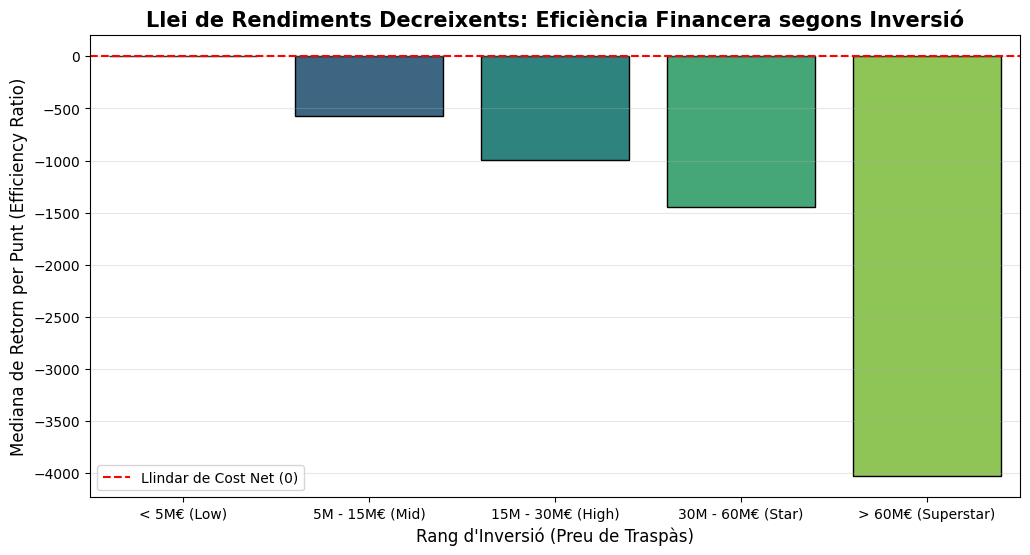

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. CREACIÓ DELS RANGS DE PREU (BUCKETS)
# Definim els talls segons la realitat del mercat (en Milions d'Euros)
bins = [0, 5000000, 15000000, 30000000, 60000000, 1000000000]
labels = ['< 5M€ (Low)', '5M - 15M€ (Mid)', '15M - 30M€ (High)', '30M - 60M€ (Star)', '> 60M€ (Superstar)']

# Creem la nova columna 'price_range'
df_clean['price_range'] = pd.cut(df_clean['transfer_fee'], bins=bins, labels=labels)

# 2. CÀLCUL DE L'EFICIÈNCIA MITJANA PER RANG
# Agrupem per rang i calculem la mitjana de la nostra ràtio d'èxit
# Recorda: Més positiu = Més Retorn per Punt. Més negatiu = Més cost.
analysis_q1 = df_clean.groupby('price_range')['efficiency_ratio'].median().reset_index()

print("--- MEDIANA D'EFICIÈNCIA PER RANG DE PREU ---")
print(analysis_q1)

# 3. VISUALITZACIÓ (Gràfic de Barres)
plt.figure(figsize=(12, 6))

# Fem servir la MEDIANA perquè és més robusta als outliers (com Yerry Mina)
sns.barplot(data=analysis_q1, x='price_range', y='efficiency_ratio', palette='viridis', edgecolor='black')

# Línia de "Break-even" (On deixes de guanyar diners i comences a perdre'n per punt)
plt.axhline(0, color='red', linestyle='--', label='Llindar de Cost Net (0)')

plt.title('Llei de Rendiments Decreixents: Eficiència Financera segons Inversió', fontsize=15, fontweight='bold')
plt.xlabel('Rang d\'Inversió (Preu de Traspàs)', fontsize=12)
plt.ylabel('Mediana de Retorn per Punt (Efficiency Ratio)', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()

📉 La Mediana del Mercat és: -61.03 €/punt

--- PROBABILITAT D'ENCERTAR EL FITXATGE (%) ---
          price_range  is_success
0         < 5M€ (Low)   58.768769
1     5M - 15M€ (Mid)   38.704581
2   15M - 30M€ (High)   35.535714
3   30M - 60M€ (Star)   31.645570
4  > 60M€ (Superstar)   10.937500


/tmp/ipython-input-1169461481.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate = df_clean.groupby('price_range')['is_success'].mean() * 100 # En percentatge
/tmp/ipython-input-1169461481.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=success_rate, x='price_range', y='is_success', palette='magma', edgecolor='black')


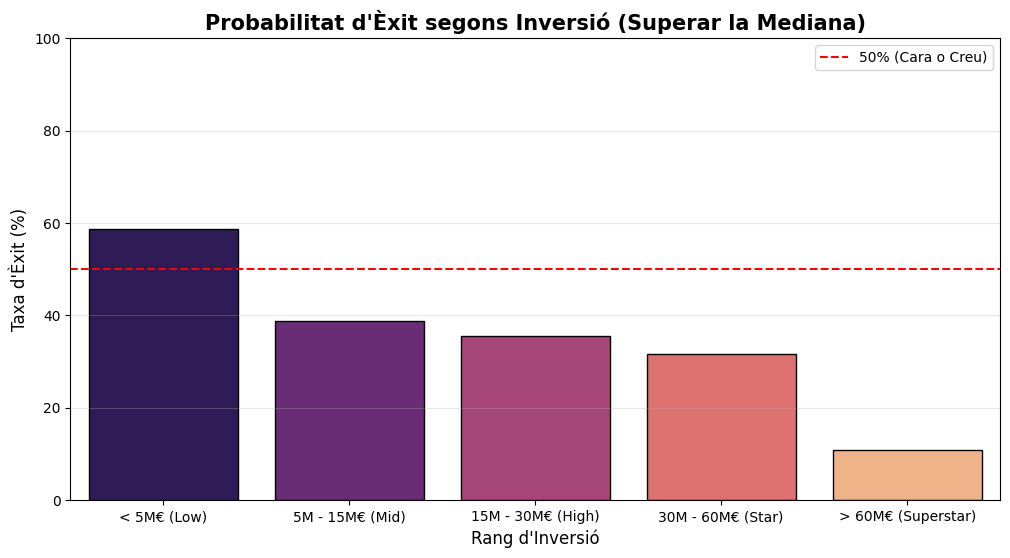

In [11]:
# 1. CÀLCUL DE LA MEDIANA DEL MERCAT (El punt de referència)
# Quin és el "cost normal" per punt al futbol?
mediana_mercat = df_clean['efficiency_ratio'].median()
print(f"📉 La Mediana del Mercat és: {mediana_mercat:.2f} €/punt")

# 2. DEFINICIÓ D'ÈXIT (Variable Binària: 1 o 0)
# Èxit = O guanyes diners (>0) O et costa menys que la mediana (ets més eficient que la mitjana)
df_clean['is_success'] = df_clean['efficiency_ratio'].apply(lambda x: 1 if x > mediana_mercat else 0)

# 3. PROBABILITAT D'ÈXIT PER RANG DE PREU
success_rate = df_clean.groupby('price_range')['is_success'].mean() * 100 # En percentatge
success_rate = success_rate.reset_index()

print("\n--- PROBABILITAT D'ENCERTAR EL FITXATGE (%) ---")
print(success_rate)

# 4. VISUALITZACIÓ
plt.figure(figsize=(12, 6))
sns.barplot(data=success_rate, x='price_range', y='is_success', palette='magma', edgecolor='black')

plt.axhline(50, color='red', linestyle='--', label='50% (Cara o Creu)')

plt.title('Probabilitat d\'Èxit segons Inversió (Superar la Mediana)', fontsize=15, fontweight='bold')
plt.xlabel('Rang d\'Inversió', fontsize=12)
plt.ylabel('Taxa d\'Èxit (%)', fontsize=12)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()

In [12]:
# BUSQUEM EL CAS BELLINGHAM (O similars del Top Mundial)
# Filtrem jugadors que van costar més de 80M€ per veure qui és un "Èxit" i qui no.

print("--- ANATOMIA D'UN SUPERSTAR (ÈXITS VS FRACASSOS) ---")

# Busquem fitxatges > 80M
df_superstars = df_clean[df_clean['transfer_fee'] > 80000000].copy()

# Ensenyem les columnes clau
cols_check = ['player_name', 'transfer_fee', 'residual_value', 'financial_balance', 'efficiency_ratio', 'is_success']

print(f"Total de Superstars analitzats: {len(df_superstars)}")
print("\n--- ELS QUE HAN SORTIT BÉ (is_success = 1) ---")
display(df_superstars[df_superstars['is_success'] == 1][cols_check].sort_values(by='efficiency_ratio', ascending=False))

print("\n--- ELS QUE HAN SORTIT MALAMENT (is_success = 0) ---")
display(df_superstars[df_superstars['is_success'] == 0][cols_check].sort_values(by='efficiency_ratio', ascending=True).head(5))

--- ANATOMIA D'UN SUPERSTAR (ÈXITS VS FRACASSOS) ---
Total de Superstars analitzats: 26

--- ELS QUE HAN SORTIT BÉ (is_success = 1) ---


,player_name,transfer_fee,residual_value,financial_balance,efficiency_ratio,is_success
2112,Jude Bellingham,113000000.0,180000000.0,67000000.0,4962.52185,1



--- ELS QUE HAN SORTIT MALAMENT (is_success = 0) ---


,player_name,transfer_fee,residual_value,financial_balance,efficiency_ratio,is_success
3733,Romelu Lukaku,113000000.0,0.0,-113000000.0,-29850.746269,0
1280,Randal Kolo Muani,95000000.0,0.0,-95000000.0,-29622.700343,0
4594,Arthur Melo,80600000.0,0.0,-80600000.0,-28304.537154,0
2572,Antony,95000000.0,0.0,-95000000.0,-19636.213311,0
3849,Jadon Sancho,85000000.0,0.0,-85000000.0,-17039.190137,0


In [17]:
import plotly.express as px

# ==============================================================================
# VISUALITZACIÓ 1 (FINAL-FINAL): MATRIU EXIGENT (SENSE SOLAPAMENTS)
# ==============================================================================

df_viz = df_clean.copy()

# 1. LLINDAR EXIGENT (TOP 25%)
ir_threshold = df_viz['IR'].quantile(0.75)

def definir_categoria(row):
    balance = row['financial_balance']
    ir = row['IR']
    if balance >= 0 and ir >= ir_threshold:
        return "ESTRELLA TOTAL"
    elif balance < 0 and ir >= ir_threshold:
        return "INVERSIÓ AMORTITZADA"
    elif balance < 0 and ir < ir_threshold:
        return "COST ENFONSAT"
    else:
        return "TRADING PUR"

df_viz['Categoria'] = df_viz.apply(definir_categoria, axis=1)

# Càlcul de percentatges
counts = df_viz['Categoria'].value_counts(normalize=True) * 100
pct_estrella = counts.get("ESTRELLA TOTAL", 0)
pct_amortitzada = counts.get("INVERSIÓ AMORTITZADA", 0)
pct_enfonsat = counts.get("COST ENFONSAT", 0)
pct_trading = counts.get("TRADING PUR", 0)

# 2. GENERACIÓ DEL GRÀFIC
fig1 = px.scatter(
    df_viz,
    x="financial_balance",
    y="IR",
    color="Categoria",
    size="transfer_fee",
    hover_name="player_name",
    hover_data=["to_club_name"],
    size_max=35,
    color_discrete_map={
        "ESTRELLA TOTAL": "#00CC96",
        "INVERSIÓ AMORTITZADA": "#636EFA",
        "COST ENFONSAT": "#EF553B",
        "TRADING PUR": "#FECB52"
    },
    title=f"<b>La Matriu de la Veritat:</b> Només el Top 25% aprova",
    labels={"financial_balance": "Resultat Econòmic (M€)", "IR": "Rendiment (Punts IR)"},
    template="plotly_white",
    opacity=0.8
)

fig1.update_traces(marker=dict(sizemin=4, line=dict(width=1, color='DarkSlateGrey')))

# 3. Línies Guia
fig1.add_vline(x=0, line_width=1, line_dash="solid", line_color="grey")
fig1.add_hline(y=ir_threshold, line_width=2, line_dash="dash", line_color="black", annotation_text=f"Tall d'Elit: {ir_threshold:.0f} pts")

# 4. ANNOTATIONS (Percentatges)
# --- CANVI CLAU: Baixem el text verd a y=0.75 per deixar espai a la llegenda ---
fig1.add_annotation(x=0.98, y=0.75, xref="paper", yref="paper", text=f"<b>{pct_estrella:.1f}%</b><br>Els Escollits", showarrow=False, font=dict(size=14, color="#00CC96"), align="right")

# La resta es queden igual
fig1.add_annotation(x=0.02, y=0.98, xref="paper", yref="paper", text=f"<b>{pct_amortitzada:.1f}%</b><br>L'Elit Costosa", showarrow=False, font=dict(size=14, color="#636EFA"), align="left")
fig1.add_annotation(x=0.02, y=0.02, xref="paper", yref="paper", text=f"<b>{pct_enfonsat:.1f}%</b><br>La Ruïna", showarrow=False, font=dict(size=14, color="#EF553B"), align="left")
fig1.add_annotation(x=0.98, y=0.02, xref="paper", yref="paper", text=f"<b>{pct_trading:.1f}%</b><br>Trading", showarrow=False, font=dict(size=14, color="#FECB52"), align="right")

# 5. DISSENY FINAL
fig1.update_xaxes(range=[-300000000, 300000000])

fig1.update_layout(
    height=700,
    xaxis_tickformat = ".2s",

    # Llegenda a dalt a la dreta (dins del requadre)
    legend=dict(
        title=None,
        orientation="v",
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="LightGrey",
        borderwidth=1,
        font=dict(size=10)
    ),
    margin=dict(t=60)
)

fig1.show()
fig1.write_html("visualitzacio_1_matriu.html")

In [14]:
import plotly.graph_objects as go
import pandas as pd

# ==============================================================================
# VISUALITZACIÓ 2: TENDÈNCIA I EFICIÈNCIA (Línia + Punts de Color)
# ==============================================================================

# 1. Preparar Dades
df_summary = df_clean.groupby('price_range', observed=False).agg(
    Mediana_Eficiencia=('efficiency_ratio', 'median'),
    Taxa_Exit=('is_success', 'mean')
).reset_index()

df_summary['Taxa_Exit'] = df_summary['Taxa_Exit'] * 100

# 2. Crear Gràfic
fig_risk = go.Figure()

# CAPA A: La Línia (per veure la baixada)
fig_risk.add_trace(go.Scatter(
    x=df_summary['price_range'],
    y=df_summary['Taxa_Exit'],
    mode='lines',
    line=dict(color='lightgrey', width=3, dash='dot'),
    hoverinfo='skip'
))

# CAPA B: Els Punts (Semàfor)
fig_risk.add_trace(go.Scatter(
    x=df_summary['price_range'],
    y=df_summary['Taxa_Exit'],
    mode='markers+text',

    marker=dict(
        size=30, # Mida FIXA (així no confon l'eix Y)
        color=df_summary['Mediana_Eficiencia'], # Color segons eficiència
        colorscale='RdYlGn',
        showscale=True, # Ensenya la barra de colors a la dreta
        colorbar=dict(title="Eficiència<br>(€/punt)"),
        line=dict(width=2, color='DarkSlateGrey')
    ),

    # Text dins del punt
    text=df_summary['Taxa_Exit'].apply(lambda x: f"{x:.1f}%"),
    textposition="middle center",
    textfont=dict(color='black', size=11, family="Arial Black"),

    hovertemplate="<b>%{x}</b><br>Probabilitat: %{y:.1f}%<br>Eficiència: %{marker.color:.0f} €/punt<extra></extra>"
))

# 3. Disseny
fig_risk.update_layout(
    title="<b>La Caiguda dels Gegants:</b> Probabilitat i Eficiència segons Inversió",
    yaxis=dict(title="Probabilitat d'Èxit (%)", range=[-5, 105]),
    xaxis=dict(title="Rang d'Inversió Inicial"),
    template="plotly_white",
    height=600,
    showlegend=False
)

fig_risk.show()
fig_risk.write_html("visualitzacio_2_semafor_final.html")

In [15]:
import plotly.express as px

# ==============================================================================
# VISUALITZACIÓ 3: RÀNQUING PER POSICIÓ (Amb Zoom)
# ==============================================================================

# 1. Dades
mapa_noms = {'Attack': 'Attacker', 'Midfield': 'Midfielder', 'Defence': 'Defender', 'Goalkeeper': 'Goalkeeper'}
df_clean['position'] = df_clean['position'].replace(mapa_noms)

df_pos_rank = df_clean.groupby('position', observed=False)['is_success'].mean() * 100
df_pos_rank = df_pos_rank.reset_index().sort_values(by='is_success', ascending=True)

# 2. Colors
color_map = {
    'Goalkeeper': '#00CC96',  # Verd
    'Defender': '#00CC96',    # Verd
    'Midfielder': '#636EFA',  # Blau
    'Attacker': '#EF553B'     # Vermell
}

# 3. Gràfic
fig3 = px.bar(
    df_pos_rank,
    x="is_success",
    y="position",
    orientation='h',
    color="position",
    color_discrete_map=color_map,
    title="<b>La Seguretat Defensiva:</b> Probabilitat d'Èxit per Posició",
    template="plotly_white",
    text=df_pos_rank['is_success'].apply(lambda x: f"{x:.1f}%")
)

# Estil "Lollipop"
fig3.update_traces(
    width=0.3,
    textposition='inside',
    textfont=dict(color='white', size=14, family="Arial Black")
)

# Boles al final
fig3.add_traces(px.scatter(
    df_pos_rank, x="is_success", y="position",
    color="position", color_discrete_map=color_map
).update_traces(marker=dict(size=25, line=dict(width=2, color='white'))).data)

# 4. Zoom clau (40-55%)
fig3.update_layout(
    height=500,
    showlegend=False,
    xaxis=dict(range=[40, 55], title="Probabilitat d'Èxit (%)"),
    yaxis=dict(title="")
)

fig3.add_vline(x=50, line_dash="dot", line_color="grey", annotation_text="50%")

fig3.show()
fig3.write_html("visualitzacio_3_posicions_final.html")